Continuing from the Feature Engineering notebook. This notebook discusses the experiments carried out to find an optimum model for the Predictor.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid', context='talk')
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


import warnings
warnings.filterwarnings('ignore')

# Preparing the Dataset


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/stock_model/dataframe_for_model.csv',
            parse_dates=['Date'],
            index_col=['Date']).dropna()

data.head()

,Volume,Move,Forecast,0,1,2,0_SPX,1_SPX,2_SPX
Date,,,,,,,,,
2015-01-07,1.005468,1,1.0,-0.033832,-0.022282,-0.017089,-0.009385,-0.020523,-0.006259
2015-01-08,1.005349,1,2.0,-0.022282,-0.017089,0.037738,-0.020523,-0.006259,0.026292
2015-01-09,1.005322,2,1.0,-0.017089,0.037738,0.016188,-0.006259,0.026292,-0.000310
2015-01-12,1.006957,1,1.0,0.037738,0.016188,-0.047262,0.026292,-0.000310,-0.005515
2015-01-13,1.008898,1,1.0,0.016188,-0.047262,0.014290,-0.000310,-0.005515,0.003234


# Baseline Model: Naive Forecast
We will simply shift the model by one day, and evaluate the performance of the model.

X[t+1] = X[t]

To do this, we have to use the original values of 'Close', not the price movements. Perform the shift. Then convert 'Close' -> 'Close'.diff() -> 'Movement'

,Close
Date,
2023-06-16,431.96
2023-06-15,445.27
2023-06-14,440.86


,Close,Close_diff
Date,,
2023-06-16,431.96,NaN
2023-06-15,445.27,0.029892
2023-06-14,440.86,-0.010003


1    1639
2     246
0     244
Name: Close_diff, dtype: int64

,Close,Close_diff,Move
Date,,,
2023-06-15,445.27,0.029892,2
2023-06-14,440.86,-0.010003,1
2023-06-13,435.73,-0.011773,1


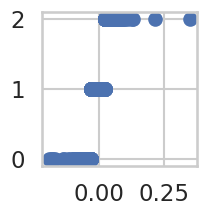

In [ ]:
# download the data

Close = pd.read_csv('/content/drive/MyDrive/stock_model/NFLX_fuller.csv',
                        parse_dates=['Date']).set_index('Date')
Close = Close['2015':]['Close'].to_frame()
display(Close.head(3))

# converting it to diff
Close['Close_diff'] = Close['Close'].diff()/Close['Close']
display(Close.head(3))
# converting it to discrete bins
from helper_functions import hypertune_bins
Close['Move'] = hypertune_bins(Close['Close_diff'], [-0.029,  0.024])

Close = Close.dropna()
Close.head(3)

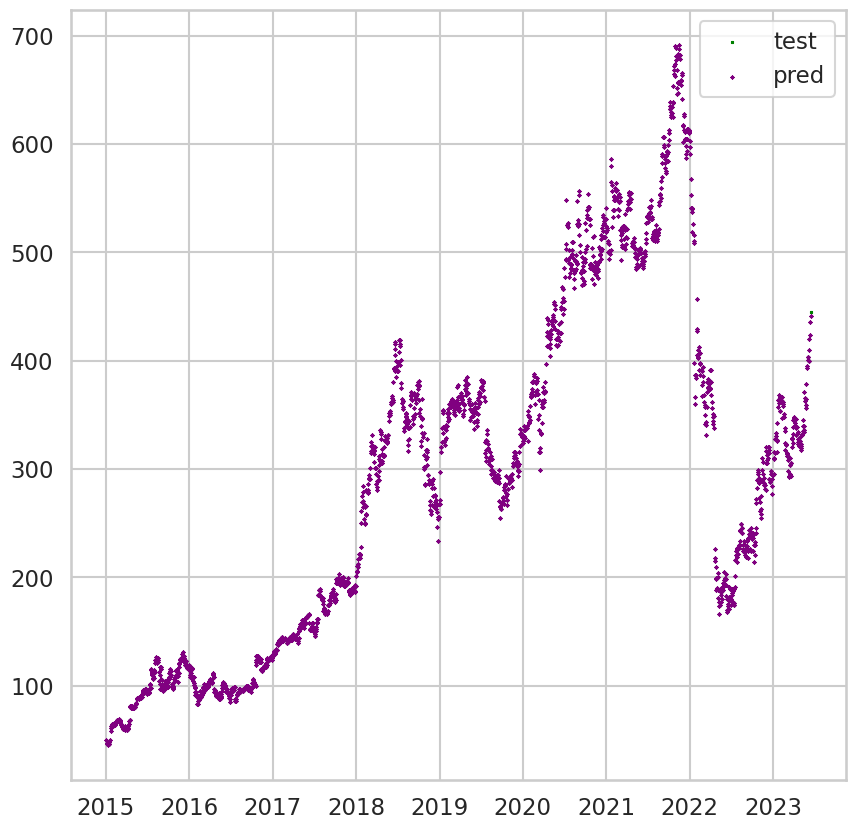

In [ ]:
# shifting the data
ytrue = Close['Close'][:-1]
ypred = Close['Close'][1:]

# visualizing this
plt.figure(figsize=(10,10))
plt.scatter(ytrue.index, ytrue, color='green', label='test', s=3, marker="+")
plt.scatter(ypred.index, ypred, color='purple', label='pred', s=3, marker="x")
plt.legend()

In [ ]:
from sklearn.metrics import accuracy_score
y_true = Close['Move'][:-1]
y_pred = Close['Move'][1:]
accuracy_score(y_true, y_pred)

0.6544428772919605

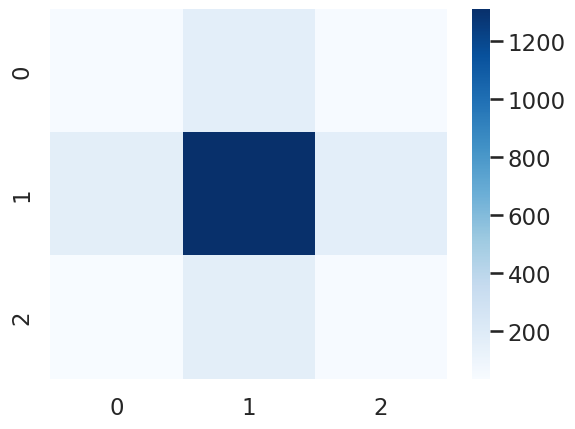

              precision    recall  f1-score   support

           0       0.17      0.17      0.17       244
           1       0.80      0.80      0.80      1638
           2       0.17      0.17      0.17       245

    accuracy                           0.65      2127
   macro avg       0.38      0.38      0.38      2127
weighted avg       0.65      0.65      0.65      2127



In [ ]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(cf_matrix, cmap='Blues')
plt.show()
print(classification_report(y_true, y_pred))

## Evaluations
To access the performance of the models, we need to establish evaluations properly.
This function will be called to append to the Evaluation dictionary.

In [ ]:
# Setting up evaluation matrix
def eval (y_true, y_pred):
    y_pred = np.squeeze(y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    clf_report = classification_report(y_true, y_pred)
    cf_matrix = confusion_matrix(y_true, y_pred)

    return {'accuracy':accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1}, \
            {'classification_report': clf_report,
            'confusion_matrix': cf_matrix}

In [ ]:
metrics_log = {}
metrics_log['baseline'], _ = eval(y_true, y_pred)
metrics_log

{'baseline': {'accuracy': 0.6544428772919605,
  'precision': 0.6544428772919605,
  'recall': 0.6544428772919605,
  'f1': 0.6544428772919605}}

# Model Experiments 🔬:


To run a series of experiments. Starting with a simple model, then a CNN model then an LSTM model and pick the one with the best performance. After that, another series of experiments will be run to test out the features.

Model Experiments:
1. Simple 3 -layer NN
2. CNN
3. LSTM RNN
4. 3-layer LSTM model with drop out.


Hyperparameter Tuning.
1. Batch size
2. CNN layer
3. Optimizers - SGD, Adamax.

### Frequent Functions

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
early_stop = EarlyStopping(monitor='accuracy', patience=10)
from tensorflow import one_hot
import tensorflow as tf

In [ ]:
def model_evaluation(model, modelname, filepath, X_test, y_test, metrics_log=metrics_log):
    """loads the saved best performing model
    and calls the eval function to evaluate it
    """
    model.load_weights(filepath)
    display("shape of x-te:", X_test.shape)
    y_pred = np.squeeze(model.predict(X_test)).argmax(axis=1)
    display("shape of y_pred:", y_pred.shape)
    scores = eval(y_test, y_pred)
    metrics_log[modelname] = scores[0]
    display(metrics_log)
    return scores


def save_best(model):
    """
    saves the best epoch performing weights into a filepath
    that is based on the name of the model
    """
    return tf.keras.callbacks.ModelCheckpoint(
        filepath='output/'+model,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='auto',
        save_best_only=True)

# function to train test split the X and y
def train_test_splits(data, test_split=0.2):
    """
    Input: X and y
    Output: X_train, X_test, y_train, y_test in that order
    """

    # data = pd.concat([data[:'2021-10'], data['2022-06':]])
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    tmp = data.copy()
    X = tmp.drop(columns=['Forecast'])
    y = tmp['Forecast'].values
    X = scaler.fit_transform(X)

    # save this scaler
    import pickle
    pickle.dump(scaler, open('output/model/scaler', 'wb'))


    split = round(len(X) * (1-test_split))
    # returns in order: X_train, X_test, y_train, y_test
    X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

    display (X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    return X_train, X_test, y_train, y_test,


def train_model(model, data, model_name, epochs=1000):
    # definining checkpoint
    early_stop = EarlyStopping(monitor='loss', patience=10)
    # train test split
    X_train, X_test, y_train, y_test = train_test_splits(data)

    history = model.fit(X_train,
           y_train,
           epochs=epochs,
           verbose=1,
           batch_size=128,
           validation_data=(X_test, y_test),
           callbacks=[early_stop, save_best(model_name)]
           ) # create ModelCheckpoint callback to save best model

    return history, 'output/'+model_name, X_test, y_test

## 1. Experiment 1: Simple 3 - layer NN
A single dense layer with
- 128 hidden units and ReLU activation

An output layer with
- softmax activation
- Adam optimizer and MAE loss function
- Batch size of 128
- 100 epochs

In [ ]:
# set up the train and test dataset
X_train, X_test, y_train, y_test = train_test_splits(data, test_split=0.2)

(1699, 8)

(425, 8)

(1699,)

(425,)

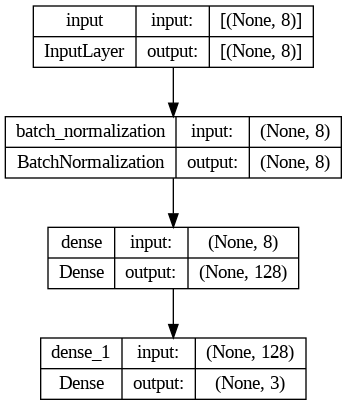

In [ ]:
# build and compile the model
model_name = "model1"
tf.random.set_seed(88)
features = len(data.columns) - 1
input = layers.Input(shape=(features,), name='input')
scaling = layers.BatchNormalization(synchronized=True)(input)
hidden = layers.Dense(128, activation='relu')(scaling)
output = layers.Dense(3, activation="softmax")(hidden)

model1 = tf.keras.Model(inputs=input,
                         outputs=output,
                         name=model_name)
# compile
model1.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
# visualize
plot_model(model1, show_shapes=True)

In [ ]:
history, filepath, X_test, y_test = train_model(model1, data, model_name, epochs=200)
model_evaluation(model1, model_name, filepath, X_test, y_test)

(1699, 8)

(425, 8)

(1699,)

(425,)

Epoch 1/200
14/14 [==============================] - 2s 31ms/step - loss: 0.9880 - accuracy: 0.6539 - val_loss: 0.9484 - val_accuracy: 0.6776
Epoch 2/200
14/14 [==============================] - 0s 4ms/step - loss: 0.8226 - accuracy: 0.7911 - val_loss: 0.9483 - val_accuracy: 0.6776
Epoch 3/200
14/14 [==============================] - 0s 5ms/step - loss: 0.7609 - accuracy: 0.7928 - val_loss: 0.9743 - val_accuracy: 0.6776
Epoch 4/200
14/14 [==============================] - 0s 5ms/step - loss: 0.7316 - accuracy: 0.7928 - val_loss: 0.9827 - val_accuracy: 0.6776
Epoch 5/200
14/14 [==============================] - 0s 6ms/step - loss: 0.7067 - accuracy: 0.7928 - val_loss: 0.9721 - val_accuracy: 0.6776
Epoch 6/200
14/14 [==============================] - 0s 5ms/step - loss: 0.6937 - accuracy: 0.7928 - val_loss: 0.9724 - val_accuracy: 0.6776
Epoch 7/200
14/14 [==============================] - 0s 5ms/step - loss: 0.6769 - accuracy: 0.7928 - val_loss: 0.9675 - val_accuracy: 0.6776
Epoch 8/200


'shape of x-te:'

(425, 8)

14/14 [==============================] - 0s 2ms/step


'shape of y_pred:'

(425,)

{'baseline': {'accuracy': 0.6544428772919605,
  'precision': 0.6544428772919605,
  'recall': 0.6544428772919605,
  'f1': 0.6544428772919605},
 'model1': {'accuracy': 0.6823529411764706,
  'precision': 0.6481568627450981,
  'recall': 0.6823529411764706,
  'f1': 0.5629476314645805}}

({'accuracy': 0.6823529411764706,
  'precision': 0.6481568627450981,
  'recall': 0.6823529411764706,
  'f1': 0.5629476314645805},
 {'classification_report': '              precision    recall  f1-score   support\n\n         0.0       0.67      0.03      0.06        61\n         1.0       0.68      1.00      0.81       288\n         2.0       0.50      0.01      0.03        76\n\n    accuracy                           0.68       425\n   macro avg       0.62      0.35      0.30       425\nweighted avg       0.65      0.68      0.56       425\n',
  'confusion_matrix': array([[  2,  58,   1],
         [  1, 287,   0],
         [  0,  75,   1]])})

## Model 2: CNN

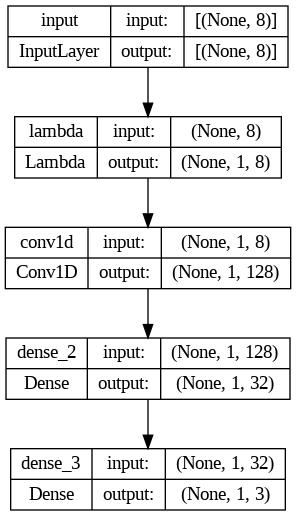

In [ ]:
# set random seed for reproducible results
tf.random.set_seed(88)
# construct model
model_name = 'model2'
features = len(data.columns) - 1
input = layers.Input(shape=(features,), name='input')
reshape = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(input)
cnn = layers.Conv1D(filters=128, kernel_size=32, padding='same', activation="relu")(reshape)
# pool = layers.MaxPool1D(3)(cnn)
dense = layers.Dense(32, activation='relu')(cnn)
output = layers.Dense(3, activation='softmax')(dense)


model2 = tf.keras.Model(inputs=input,
                         outputs=output,
                         name=model_name)
model2.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
# visualize
plot_model(model2, show_shapes=True)

In [ ]:
history2, filepath, X_test, y_test = train_model(model2, data, model_name, epochs=200)
model_evaluation(model2, model_name, filepath, X_test, y_test)

(1699, 8)

(425, 8)

(1699,)

(425,)

Epoch 1/200
14/14 [==============================] - 1s 27ms/step - loss: 1.0725 - accuracy: 0.5666 - val_loss: 1.0291 - val_accuracy: 0.6619
Epoch 2/200
14/14 [==============================] - 0s 6ms/step - loss: 0.9544 - accuracy: 0.7931 - val_loss: 0.9648 - val_accuracy: 0.6619
Epoch 3/200
14/14 [==============================] - 0s 5ms/step - loss: 0.8393 - accuracy: 0.7923 - val_loss: 0.9438 - val_accuracy: 0.6619
Epoch 4/200
14/14 [==============================] - 0s 6ms/step - loss: 0.7471 - accuracy: 0.7927 - val_loss: 0.9621 - val_accuracy: 0.6619
Epoch 5/200
14/14 [==============================] - 0s 7ms/step - loss: 0.6892 - accuracy: 0.7918 - val_loss: 0.9525 - val_accuracy: 0.6619
Epoch 6/200
14/14 [==============================] - 0s 6ms/step - loss: 0.6588 - accuracy: 0.7936 - val_loss: 0.9325 - val_accuracy: 0.6619
Epoch 7/200
14/14 [==============================] - 0s 6ms/step - loss: 0.6375 - accuracy: 0.7899 - val_loss: 0.9122 - val_accuracy: 0.6619
Epoch 8/200


'shape of x-te:'

(425, 8)

14/14 [==============================] - 0s 2ms/step


'shape of y_pred:'

(425,)

{'baseline': {'accuracy': 0.6544428772919605,
  'precision': 0.6544428772919605,
  'recall': 0.6544428772919605,
  'f1': 0.6544428772919605},
 'model1': {'accuracy': 0.6823529411764706,
  'precision': 0.6481568627450981,
  'recall': 0.6823529411764706,
  'f1': 0.5629476314645805},
 'model2': {'accuracy': 0.6776470588235294,
  'precision': 0.4592055363321799,
  'recall': 0.6776470588235294,
  'f1': 0.5474399801996535}}

({'accuracy': 0.6776470588235294,
  'precision': 0.4592055363321799,
  'recall': 0.6776470588235294,
  'f1': 0.5474399801996535},
 {'classification_report': '              precision    recall  f1-score   support\n\n         0.0       0.00      0.00      0.00        61\n         1.0       0.68      1.00      0.81       288\n         2.0       0.00      0.00      0.00        76\n\n    accuracy                           0.68       425\n   macro avg       0.23      0.33      0.27       425\nweighted avg       0.46      0.68      0.55       425\n',
  'confusion_matrix': array([[  0,  61,   0],
         [  0, 288,   0],
         [  0,  76,   0]])})

## Model 3 - Single Layer LSTM

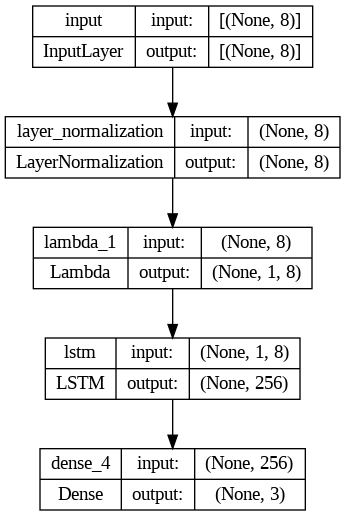

In [ ]:
# set random seed for reproducible results
tf.random.set_seed(88)
model_name = 'model3_lstm'
# building the dropout model
features = len(data.columns) - 1
input = layers.Input(shape=(features,), name='input')
scaling = layers.LayerNormalization()(input)

reshape = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(scaling)
lstm = layers.LSTM(256, dropout=0.1)(reshape)

output = layers.Dense(3, activation='softmax')(lstm)

model3 = tf.keras.Model(inputs=input,
                        outputs=output,
                        name=model_name)


model3.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
# visualize
plot_model(model3, show_shapes=True)

In [ ]:
history3, filepath, X_test, y_test = train_model(model3, data, model_name, epochs=500)
model_evaluation(model3, model_name, filepath, X_test, y_test)

(1699, 8)

(425, 8)

(1699,)

(425,)

Epoch 1/500
14/14 [==============================] - 3s 62ms/step - loss: 1.0580 - accuracy: 0.5550 - val_loss: 1.0237 - val_accuracy: 0.6071
Epoch 2/500
14/14 [==============================] - 0s 17ms/step - loss: 0.9681 - accuracy: 0.6557 - val_loss: 0.9506 - val_accuracy: 0.6471
Epoch 3/500
14/14 [==============================] - 0s 18ms/step - loss: 0.8728 - accuracy: 0.7098 - val_loss: 0.8848 - val_accuracy: 0.6659
Epoch 4/500
14/14 [==============================] - 0s 16ms/step - loss: 0.7715 - accuracy: 0.7557 - val_loss: 0.8452 - val_accuracy: 0.6776
Epoch 5/500
14/14 [==============================] - 0s 15ms/step - loss: 0.6879 - accuracy: 0.7911 - val_loss: 0.8461 - val_accuracy: 0.6776
Epoch 6/500
14/14 [==============================] - 0s 15ms/step - loss: 0.6487 - accuracy: 0.7928 - val_loss: 0.8776 - val_accuracy: 0.6776
Epoch 7/500
14/14 [==============================] - 0s 16ms/step - loss: 0.6445 - accuracy: 0.7928 - val_loss: 0.8888 - val_accuracy: 0.6776
Epoch 

'shape of x-te:'

(425, 8)

14/14 [==============================] - 0s 3ms/step


'shape of y_pred:'

(425,)

{'baseline': {'accuracy': 0.6544428772919605,
  'precision': 0.6544428772919605,
  'recall': 0.6544428772919605,
  'f1': 0.6544428772919605},
 'model1': {'accuracy': 0.6823529411764706,
  'precision': 0.6481568627450981,
  'recall': 0.6823529411764706,
  'f1': 0.5629476314645805},
 'model2': {'accuracy': 0.6776470588235294,
  'precision': 0.4592055363321799,
  'recall': 0.6776470588235294,
  'f1': 0.5474399801996535},
 'model3_lstm': {'accuracy': 0.6776470588235294,
  'precision': 0.4592055363321799,
  'recall': 0.6776470588235294,
  'f1': 0.5474399801996535}}

({'accuracy': 0.6776470588235294,
  'precision': 0.4592055363321799,
  'recall': 0.6776470588235294,
  'f1': 0.5474399801996535},
 {'classification_report': '              precision    recall  f1-score   support\n\n         0.0       0.00      0.00      0.00        61\n         1.0       0.68      1.00      0.81       288\n         2.0       0.00      0.00      0.00        76\n\n    accuracy                           0.68       425\n   macro avg       0.23      0.33      0.27       425\nweighted avg       0.46      0.68      0.55       425\n',
  'confusion_matrix': array([[  0,  61,   0],
         [  0, 288,   0],
         [  0,  76,   0]])})

## Model 4 - 3 layer LSTM

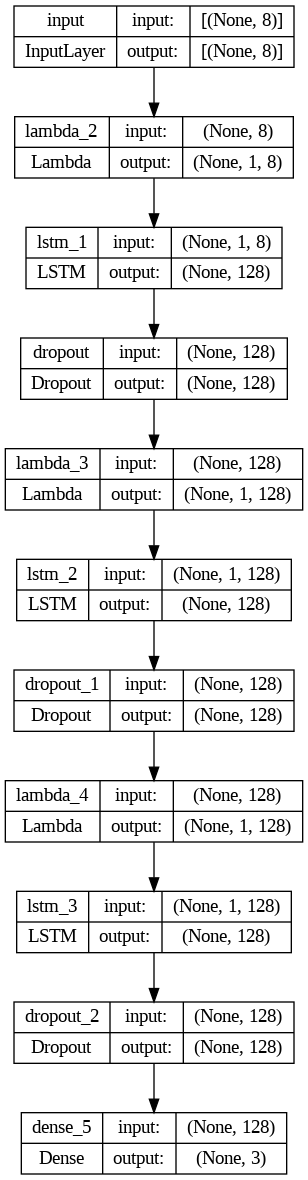

In [ ]:
# set random seed for reproducible results
tf.random.set_seed(88)
model_name = 'model4_lstm3'
# building the dropout model
features = len(data.columns) - 1
input = layers.Input(shape=(features,), name='input')

reshape = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(input)
lstm = layers.LSTM(128)(reshape)
drop1 = layers.Dropout(0.2)(lstm)
reshape2 = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(drop1)
lstm2 = layers.LSTM(128)(reshape2)
drop2 = layers.Dropout(0.2)(lstm2)
reshape3 = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(drop2)
lstm3 = layers.LSTM(128)(reshape3)
drop3 = layers.Dropout(0.2)(lstm3)

output = layers.Dense(3, activation='softmax')(drop3)

model4 = tf.keras.Model(inputs=input,
                        outputs=output,
                        name=model_name)

model4.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
# visualize
plot_model(model4, show_shapes=True)

In [ ]:
history4, filepath, X_test, y_test = train_model(model4, data, model_name, epochs=500)
model_evaluation(model4, model_name, filepath, X_test, y_test)

(1699, 8)

(425, 8)

(1699,)

(425,)

Epoch 1/500
14/14 [==============================] - 14s 137ms/step - loss: 1.0765 - accuracy: 0.7593 - val_loss: 1.0531 - val_accuracy: 0.6776
Epoch 2/500
14/14 [==============================] - 0s 36ms/step - loss: 0.9873 - accuracy: 0.7928 - val_loss: 0.9425 - val_accuracy: 0.6776
Epoch 3/500
14/14 [==============================] - 1s 41ms/step - loss: 0.7908 - accuracy: 0.7928 - val_loss: 0.8867 - val_accuracy: 0.6776
Epoch 4/500
14/14 [==============================] - 1s 40ms/step - loss: 0.6657 - accuracy: 0.7922 - val_loss: 0.9831 - val_accuracy: 0.6776
Epoch 5/500
14/14 [==============================] - 1s 41ms/step - loss: 0.6432 - accuracy: 0.7928 - val_loss: 0.8906 - val_accuracy: 0.6776
Epoch 6/500
14/14 [==============================] - 1s 38ms/step - loss: 0.6356 - accuracy: 0.7946 - val_loss: 0.9069 - val_accuracy: 0.6776
Epoch 7/500
14/14 [==============================] - 1s 38ms/step - loss: 0.6306 - accuracy: 0.7928 - val_loss: 0.8927 - val_accuracy: 0.6776
Epoc

'shape of x-te:'

(425, 8)

14/14 [==============================] - 1s 3ms/step


'shape of y_pred:'

(425,)

{'baseline': {'accuracy': 0.6544428772919605,
  'precision': 0.6544428772919605,
  'recall': 0.6544428772919605,
  'f1': 0.6544428772919605},
 'model1': {'accuracy': 0.6823529411764706,
  'precision': 0.6481568627450981,
  'recall': 0.6823529411764706,
  'f1': 0.5629476314645805},
 'model2': {'accuracy': 0.6776470588235294,
  'precision': 0.4592055363321799,
  'recall': 0.6776470588235294,
  'f1': 0.5474399801996535},
 'model3_lstm': {'accuracy': 0.6776470588235294,
  'precision': 0.4592055363321799,
  'recall': 0.6776470588235294,
  'f1': 0.5474399801996535},
 'model4_lstm3': {'accuracy': 0.68,
  'precision': 0.6038179800221976,
  'recall': 0.68,
  'f1': 0.5528388376010064}}

({'accuracy': 0.68,
  'precision': 0.6038179800221976,
  'recall': 0.68,
  'f1': 0.5528388376010064},
 {'classification_report': '              precision    recall  f1-score   support\n\n         0.0       1.00      0.02      0.03        61\n         1.0       0.68      1.00      0.81       288\n         2.0       0.00      0.00      0.00        76\n\n    accuracy                           0.68       425\n   macro avg       0.56      0.34      0.28       425\nweighted avg       0.60      0.68      0.55       425\n',
  'confusion_matrix': array([[  1,  60,   0],
         [  0, 288,   0],
         [  0,  76,   0]])})

# Hyperparameter Tuning

I will hyperparameter tune the CNN/LSTM layer.

1. Training Batch size - 32, 128
2. Number of LSTM nodes - 32, 128
3. CNN layer - True or False
4. optimizer - adam, sgd

In [ ]:
# these 2 functions need to be modified
# to enable hyperparameter tuning

def model_building_compiling_tuning(data,
                             lstm_nodes=128,
                                    cnn = False,
                             opt='adam'):

    """inputs: the training dataset
    outputs: an LSTM model
    """
    tf.random.set_seed(88)
    features = len(data.columns) - 1 # extracting the number of features to check the shape

    # building the CNN model
    input = layers.Input(shape=(features,), name='input')
    reshape = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(input)
    if cnn == True:

        cnn_layer = layers.Conv1D(filters=128, kernel_size=32, padding='same', activation="relu")(reshape)
        max = layers.GlobalMaxPooling1D()(cnn_layer)
        cnn_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(max)
        x = cnn_layer
    else:
        x = reshape

    lstm = layers.LSTM(lstm_nodes)(x)
    output = layers.Dense(3, activation='softmax')(lstm)

    model = tf.keras.Model(inputs=input,
                            outputs=output,
                            name="model")

    # visualizing the model
    plot_model(model, show_shapes=True)
    # compiling the model
    model.compile(loss="sparse_categorical_crossentropy",
                optimizer=opt,
                metrics=["accuracy"])
    return model

def model_training_tuning(model, data, model_name, epochs=5,
                   batch_size=32):
    """
    splits the dataset into training/test and fits the model
    inputs: the compiled model, and the X, y dataset and the model_name for the checkpoint
    outputs: the split dataset X_test, y_test
    log (history) of the model fitting process,
    the filepath for the checkpoints
    """
    # split the data
    X_train, X_test, y_train, y_test = train_test_splits(data, test_split=0.25)

    #checkpoints
    early_stop = EarlyStopping(monitor='loss', patience=10)

    # Fit model
    history = model.fit(X_train,
           y_train,
           epochs=epochs,
           verbose=0,
           batch_size=32,
           validation_data=(X_test, y_test),
           callbacks=[early_stop, save_best(model_name)]
           ) # create ModelCheckpoint callback to save best model

    return history, 'output/'+model_name, X_test, y_test

In [ ]:
def build_model_tuning():
    """
    modification of the original build_model function
    for hyperparameter tuning
    """

    from sklearn.model_selection import ParameterGrid
    # putting the hyperparameters into a grid
    params = {
            'batch_size' : [16, 32],
            'lstm_nodes' : [32, 128],
            'cnn' : [True, False],
            'opt' : ['adam', 'sgd']
        }
    param_grid = ParameterGrid(params)

    # start the GridSearch
    for dict_ in tqdm(param_grid):
        print('Parameters :', dict_.values())
        batch_size, cnn, lstm_nodes, opt = dict_.values()
        model_name = f"hypertuning_{batch_size}_{lstm_nodes}_{cnn}_{opt}"
        print(batch_size, cnn, lstm_nodes, opt)
        # build and compile the model

        model = model_building_compiling_tuning(data, lstm_nodes,
                             cnn,
                             opt)
        display(plot_model(model, show_shapes=True))

        # train the model
        model_name = model_name
        _, filepath, X_test, y_test = model_training_tuning(model, data,
                                                            model_name, epochs=250, batch_size = batch_size)

        # evaluate the model
        model_evaluation(model, model_name, filepath, X_test, y_test)



# from tqdm import tqdm
# build_model_tuning()

### Results

In [ ]:
results = pd.DataFrame(metrics_log).T

In [ ]:
results.to_csv('/content/drive/MyDrive/stock_model/hyperparametertuning_results.csv')

In [ ]:
results

,accuracy,precision,recall,f1
baseline,0.654443,0.654443,0.654443,0.654443
model1,0.682353,0.648157,0.682353,0.562948
model2,0.677647,0.459206,0.677647,0.547440
model3_lstm,0.677647,0.459206,0.677647,0.547440
model4_lstm3,0.680000,0.603818,0.680000,0.552839
hypertuning_16_32_True_adam,0.734463,0.658213,0.734463,0.623891
hypertuning_16_32_True_sgd,0.732580,0.536674,0.732580,0.619508
hypertuning_16_128_True_adam,0.734463,0.658213,0.734463,0.623891
hypertuning_16_128_True_sgd,0.732580,0.536674,0.732580,0.619508
hypertuning_16_32_False_adam,0.738230,0.662004,0.738230,0.649337


In [ ]:
results.idxmax(axis=0)

accuracy      hypertuning_16_32_False_adam
precision    hypertuning_128_128_True_adam
recall        hypertuning_16_32_False_adam
f1                                baseline
dtype: object

In [ ]:
# retraining the best model to save it
# train the model
model_name = 'hypertuning_128_128_True_adam'
model = model_building_compiling_tuning(data, lstm_nodes=128,
                             cnn=True,
                             opt='adam')
_, filepath, X_test, y_test = model_training_tuning(model, data,
                                                    model_name, epochs=250, batch_size = 128)

# evaluate the model
scores = model_evaluation(model, model_name, filepath, X_test, y_test)

(1593, 8)

(531, 8)

(1593,)

(531,)

'shape of x-te:'

(531, 8)

17/17 [==============================] - 1s 2ms/step


'shape of y_pred:'

(531,)

{'baseline': {'accuracy': 0.6544428772919605,
  'precision': 0.6544428772919605,
  'recall': 0.6544428772919605,
  'f1': 0.6544428772919605},
 'model1': {'accuracy': 0.6823529411764706,
  'precision': 0.6481568627450981,
  'recall': 0.6823529411764706,
  'f1': 0.5629476314645805},
 'model2': {'accuracy': 0.6776470588235294,
  'precision': 0.4592055363321799,
  'recall': 0.6776470588235294,
  'f1': 0.5474399801996535},
 'model3_lstm': {'accuracy': 0.6776470588235294,
  'precision': 0.4592055363321799,
  'recall': 0.6776470588235294,
  'f1': 0.5474399801996535},
 'model4_lstm3': {'accuracy': 0.68,
  'precision': 0.6038179800221976,
  'recall': 0.68,
  'f1': 0.5528388376010064},
 'hypertuning_16_32_True_adam': {'accuracy': 0.7344632768361582,
  'precision': 0.6582134100842127,
  'recall': 0.7344632768361582,
  'f1': 0.6238905448215495},
 'hypertuning_16_32_True_sgd': {'accuracy': 0.7325800376647834,
  'precision': 0.5366735115849356,
  'recall': 0.7325800376647834,
  'f1': 0.6195079014165

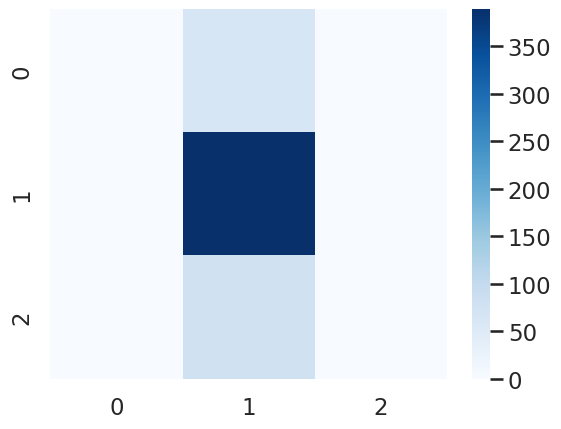

              precision    recall  f1-score   support

         0.0       1.00      0.02      0.03        64
         1.0       0.73      1.00      0.85       389
         2.0       0.00      0.00      0.00        78

    accuracy                           0.73       531
   macro avg       0.58      0.34      0.29       531
weighted avg       0.66      0.73      0.62       531



In [ ]:
# printing out results
cf_matrix = scores[1]['confusion_matrix']
classif_report = scores[1]['classification_report']
sns.heatmap(cf_matrix, cmap='Blues')
plt.show()
print(classif_report)

# Deployment

The model will be deployed on a cloud-hosted environment and we will be able to access its predictions. The process to this involves:

1. Saving and loading the model
2. Saving the most recent record of the database which will be used as input to the model for the next day's prediction.
3. The Flask-based app that will be used to broadcast the model's results.
4. The schedule()-based app that will retrieve the latest information of NFLX from the Financial API.

This is the website: http://ec2-18-220-177-255.us-east-2.compute.amazonaws.com:8000/

In [ ]:
# saving the model


model.save('output/model/best_model')


* This concludes the report on the stock predictor model. You can find the functions in the files